<a href="https://colab.research.google.com/github/IrisFDTD/AI-UNIZAR-course/blob/main/minst/ai_unizar_course_classifying_digits_23-24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Licencia Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">*Introducción a la inteligencia artificial: redes neuronales avanzadas con Tensorflow-Keras*</span> por <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Sergio Gutiérrez Rodrigo (sergut@unizar.es)</span> se distribuye bajo una <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Licencia Creative Commons Atribución-NoComercial-CompartirIgual 4.0 Internacional</a>.

```
Sergio G Rodrigo
Departamento de Física Aplicada
Universidad de Zaragoza
Instituto de Nanociencia y Materiales de Aragón (INMA)
C/ Pedro Cerbuna, 12, 50009, Zaragoza, España
```






# **Advanced Neural Networks with TensorFlow-Keras**

---
# **Handwritten digit classification with Convolutional Neural Networks (CNN)**
---


# Auxiliary functions

In [ ]:
%matplotlib inline
import numpy as np
import random

# Two functions for digits visualization
def show_one_digit(digit, npixelsx):
    import matplotlib.pyplot as plt
    plt.figure()
    plt.imshow(digit.reshape([npixelsx, npixelsx]))
    plt.show()

def show_n_m_digits(n, m, digits, labels, npixels_x):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(n*2, m*2))
    columns = n
    rows = m
    ax = []
    for i in range(columns*rows):
        img = digits[i,:].reshape([npixels_x,npixels_x])
        # create subplot and append to ax
        ax.append( fig.add_subplot(rows, columns, i+1) )
        ax[-1].set_title("label:"+str(labels[i]))  # set title
        plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
        plt.imshow(img)
    plt.show()

# An alternative to GraphData() function
def plot_score(pathresults,history_keras,loss_name,metrics_name):
    import numpy as np
    import matplotlib.pyplot as plt
    import os

    history_dict=history_keras.history
    training_cost=history_dict[loss_name]
    training_accuracy=history_dict[metrics_name]
    evaluation_cost=history_dict['val_'+loss_name]
    evaluation_accuracy=history_dict['val_'+metrics_name]

    epochs=len(evaluation_cost)
    print("Número de épocas: %d\n" % (epochs))
    xx = np.linspace(0,epochs-1,epochs)
    # in a file
    filemse="/loss_mse_.dat"
    file=os.path.exists(pathresults+filemse)
    if (file):
        os.remove(pathresults+filemse)
        print(pathresults+filemse+" removed")
    with open(pathresults+filemse, 'w') as f1:
       for i in range(0,epochs):
           summary= str(xx[i])+' '+str(evaluation_cost[i])+' '+str(evaluation_accuracy[i])+' '+str(training_cost[i])+' '+str(training_accuracy[i])+''+'\n'
           f1.write(summary)
    f1.close()

    # as a figure
    # Four axis
    fig2, ax2 = plt.subplots(2,2, figsize=(10,10)) #sharex='col', sharey='row',
    ax2[0,0].plot(xx,evaluation_cost, color="red", label="Loss (validation)")
    ax2[0,1].plot(xx,evaluation_accuracy, color="blue", label="Metrics (validation)")
    ax2[1,0].plot(xx,training_cost, color="orange", label="Loss (training)")
    ax2[1,1].plot(xx,training_accuracy, color="cyan", label="Metrics (training)")
    txt = "Epochs"
    ax2[0,0].set_xlabel(txt)
    ax2[0,0].legend()
    ax2[0,1].set_xlabel(txt)
    ax2[0,1].legend()
    ax2[1,0].set_xlabel(txt)
    ax2[1,0].legend()
    ax2[1,1].set_xlabel(txt)
    ax2[1,1].legend()
    fig2.savefig(pathresults+"/epochs_evolution.png", dpi=200, facecolor="#f1f1f1")

# Load training and validation datasets (MINST)

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_val, y_val) = mnist.load_data()

output_neurons=10 # Output in the range of [0,9]

n_train=50000   # <= 50000
n_val=10000    # <= 10000

# A subset of training/test data
x_train= x_train[0:n_train]
y_train=y_train[0:n_train]
x_val= x_val[0:n_val]
y_val=y_val[0:n_val]
'''
Nielsen x.shape = (784,1)
Keras x.shape =(784,)
'''
x_train_len=len(x_train)
x_val_len=len(x_val)
print("(train _len,test len)=",x_train_len,x_val_len)
x_train = x_train.reshape(x_train_len, 784)
x_val = x_val.reshape(x_val_len, 784)
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_train /= 255
x_val /= 255

11490434/11490434 [==============================] - 0s 0us/step
(train _len,test len)= 50000 10000


## A look at the data structure

In [ ]:
x=x_train
y=y_train
print('number of images', x.shape[0])
print('number of pixels', x.shape[1])
print('different labels', np.unique(y))
print('number of instances of each pixel', [np.count_nonzero(y == i) for i in np.unique(y)])

number of images 50000
number of pixels 784
different labels [0 1 2 3 4 5 6 7 8 9]
number of instances of each pixel [4932, 5678, 4968, 5101, 4859, 4506, 4951, 5175, 4842, 4988]


## Shuffle the data

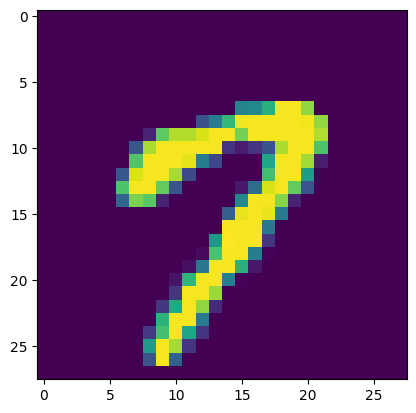

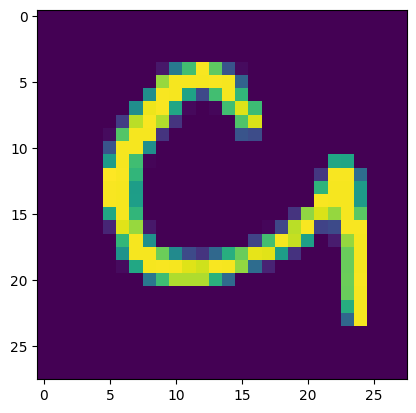

In [ ]:
# shuffle the data
nimagenes=x_train.shape[0]
npixelsx=28
npixelsy=28

# Show two examples (before randomize)
show_one_digit(x_train[15,:], npixelsx)

# Shuffle training dataset
shuffle_list = np.random.permutation(range(nimagenes))
x_train = x_train[shuffle_list, :]
y_train = y_train[shuffle_list]

# Show two examples (after randomize)
show_one_digit(x_train[15,:], npixelsx)

## One hot enconding

In [ ]:
# convert class vectors to binary class matrices (one hot encoding)
y1h_train = tf.keras.utils.to_categorical(y_train, output_neurons)
y1h_val = tf.keras.utils.to_categorical(y_val, output_neurons)

In [ ]:
print(y_train[0:10])
print(y1h_train[0:10])

[2 6 4 7 6 4 0 5 4 8]
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


### Exploring the data

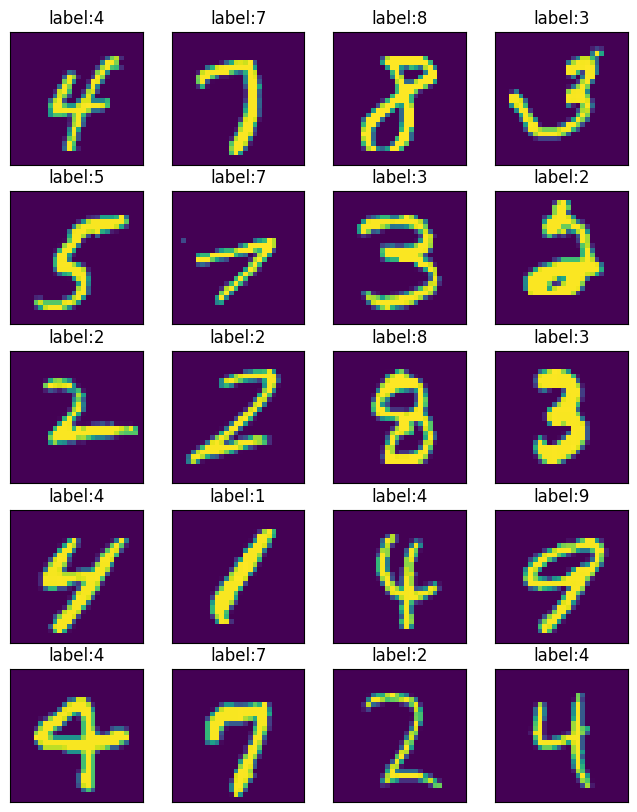

In [ ]:
n = 4; m = 5
show_n_m_digits(n, m, x_train[20:40,:], y_train[20:40], npixelsx)

# **Dense layers**


In [ ]:
# To run the Tensorflow Keras models set to True
run_tf_keras=True

50000 train samples
10000 test samples
x_train shape (50000, 784)
y1h_train shape (50000, 10)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                11775     
                                                                 
 dense_1 (Dense)             (None, 10)                160       
                                                                 
Total params: 11935 (46.62 KB)
Trainable params: 11935 (46.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
5000/5000 [==============================] - 20s 3ms/step - loss: 0.4135 - accuracy: 0.8761 - val_loss: 0.3194 - val_accuracy: 0.9037
Epoch 2/10
5000/5000 [==============================] - 15s 3ms/step - loss: 0.3078 - accuracy: 0.9104 - val_loss: 0.3237 - val_accuracy: 0.9126
Epoch 3/10
5000/5000 [==========

<ipython-input-9-d7eb31882daf>:43: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  models.save_model(model,'./model_dense_simple.h5',save_format='h5')


Keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Número de épocas: 10



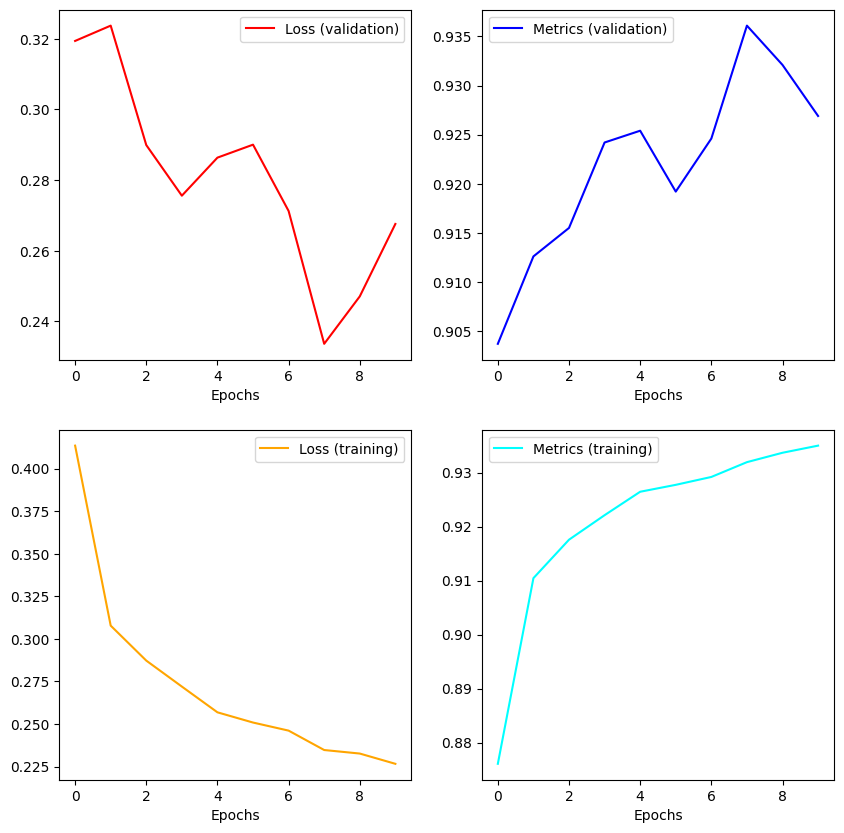

In [ ]:
# Tensorflow Keras packages
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.optimizers import SGD

# Check data and labels previously defined
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'test samples')
print("x_train shape",x_train.shape)
print("y1h_train shape",y1h_train.shape)

# Input and output neurons (from the data)
input_neurons  = x_train.shape[1]
output_neurons = y1h_train.shape[1]

# Hiperparameters
batch_size = 10
epochs = 10
eta = 1.0
hidden_layer_neurons=15

# Define the model
model = Sequential()
model.add(Input(shape=(input_neurons,)))
model.add(Dense(hidden_layer_neurons, activation='sigmoid'))
model.add(Dense(output_neurons, activation='sigmoid'))
model.summary()

optimizer=SGD(learning_rate=eta)

model.compile(loss='categorical_crossentropy',
          optimizer=optimizer,
          metrics=['accuracy'])

if(run_tf_keras):
    history = model.fit(x_train, y1h_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_val, y1h_val))
   # Guardar el modelo
    model.save('./model_dense_simple.keras')
   # history from training
    print("Keys:",history.history.keys())
    plot_keys=list(history.history.keys())
    plot_score("./",history,loss_name=plot_keys[0],metrics_name=plot_keys[1])


## **Plotting the results: model summary, score and performance** <a name="Plots"></a>

In [ ]:
from tensorflow.keras import models

model=models.load_model('./model_dense_simple.keras')
model.summary()
score = model.evaluate(x_val, y1h_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                11775     
                                                                 
 dense_1 (Dense)             (None, 10)                160       
                                                                 
Total params: 11935 (46.62 KB)
Trainable params: 11935 (46.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Test loss: 0.2675836980342865
Test accuracy: 0.9269000291824341


## How wierd are those digits the model did not catch?

### A few auxiliary functions

In [ ]:
def inverse_one_hot_enconding(y_enconded):
     y = np.argmax(y_enconded,axis=1)
     return y

def fail_to_predict(model,model_name,x,y):
    y_pred=model.predict(x)
    y_pred_num=inverse_one_hot_enconding(y_pred)
    y_num=inverse_one_hot_enconding(y)
    dif=list(y_pred_num-y_num)
    fail_to_predict_index=[indx for indx,val in enumerate(dif) if val!=0]
    accu=(len(y)-len(fail_to_predict_index))/len(y)
    print("Model %s FAILED to predict %.f labels out of %.f. Accuracy= %.4f \n" %(model_name,len(fail_to_predict_index),len(y),accu))
    return fail_to_predict_index

def show_wierd_digits(model_filename,x,y,no_digits,npixelsx,verbose=0):
    model=models.load_model(model_filename+'.h5')
    fail_to_predict_index=fail_to_predict(model,model_filename,x,y)
    n=no_digits
    x_fail=x[fail_to_predict_index[0:n**2]]
    y_fail=y[fail_to_predict_index[0:n**2]]
    y_fail=inverse_one_hot_enconding(y_fail)
    y_fail=np.reshape(y_fail,(y_fail.shape[0],1))
    if(verbose==1):
      model.summary()
      show_n_m_digits(n,n, x_fail, y_fail,npixelsx)
    return  model,fail_to_predict_index

### Check performance

313/313 [==============================] - 0s 1ms/step
Model model_dense_simple FAILED to predict 731 labels out of 10000. Accuracy= 0.9269 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                11775     
                                                                 
 dense_1 (Dense)             (None, 10)                160       
                                                                 
Total params: 11935 (46.62 KB)
Trainable params: 11935 (46.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


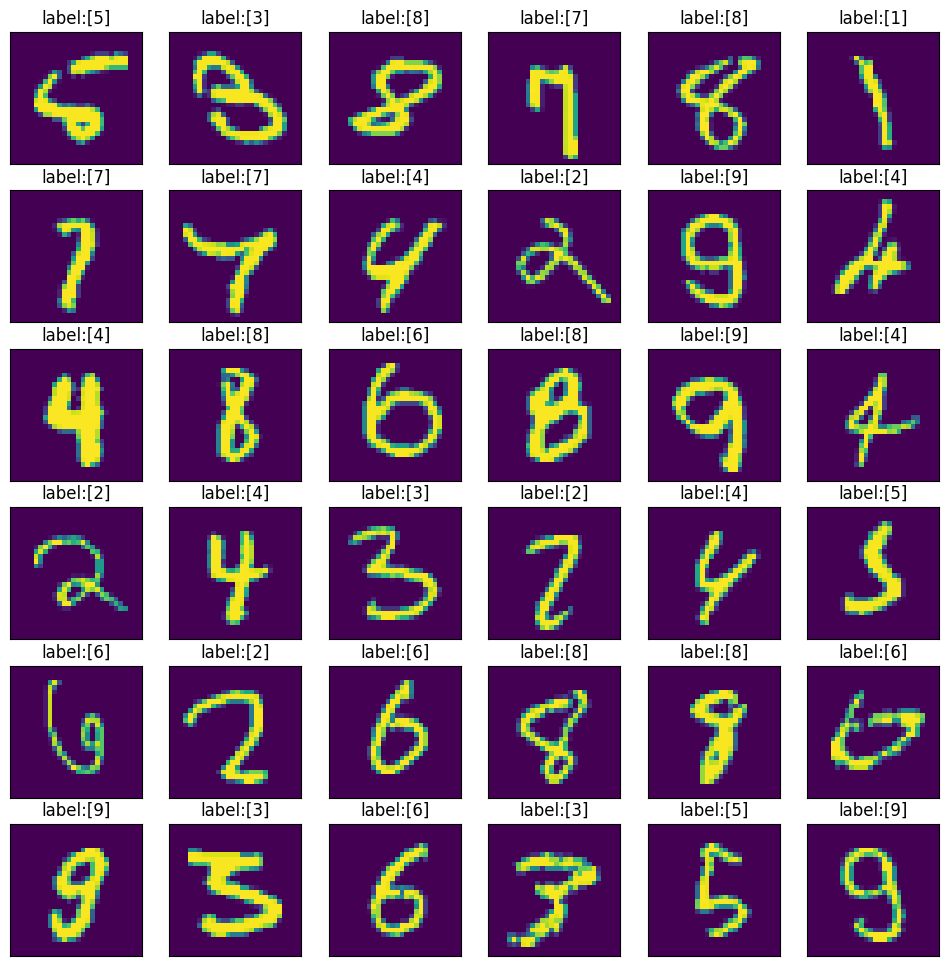

Simple model failed to predict digits  731


In [ ]:
# We load the simple keras model and create a list with digits
# unable to predict by the model
model_dense_simple,fail_to_predict_index_simple=show_wierd_digits('model_dense_simple',x_val,y1h_val,6,npixelsx,verbose=1)
simple=set(fail_to_predict_index_simple)
print("Simple model failed to predict digits ",len(simple))

# **Convolutional  Neural Networks (CNN)**

### Adapt data to CONV2D



In [ ]:
# Previous shapes of {data,labels}
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'test samples')
print("old x_train shape",x_train.shape)
print("old y1h_train shape",y1h_train.shape)

# From digits-like rows to digits
input_channels=1
def x_from_dense_to_conv2d(x,pixels,input_channels):
     return x.reshape((len(x),pixels,pixels,input_channels))

x_train_conv2d=x_from_dense_to_conv2d(x_train,npixelsx,1)
x_val_conv2d=x_from_dense_to_conv2d(x_val,npixelsx,1)

# New shapes of {data,labels}
print("\n new conv2D x_train shape",x_train_conv2d.shape)
print("y1h_train shape doesn't change")

img_cols=x_train_conv2d.shape[1]
img_rows=x_train_conv2d.shape[2]
input_shape = (img_cols,img_rows,input_channels)

50000 train samples
10000 test samples
old x_train shape (50000, 784)
old y1h_train shape (50000, 10)

 new conv2D x_train shape (50000, 28, 28, 1)
y1h_train shape doesn't change


### Run a convnet based on Tensorflow Keras

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)              

<ipython-input-19-532f75bbc5d0>:43: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  models.save_model(model,'./model_conv2d.h5',save_format='h5')


Keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Número de épocas: 8

.//loss_mse_.dat removed


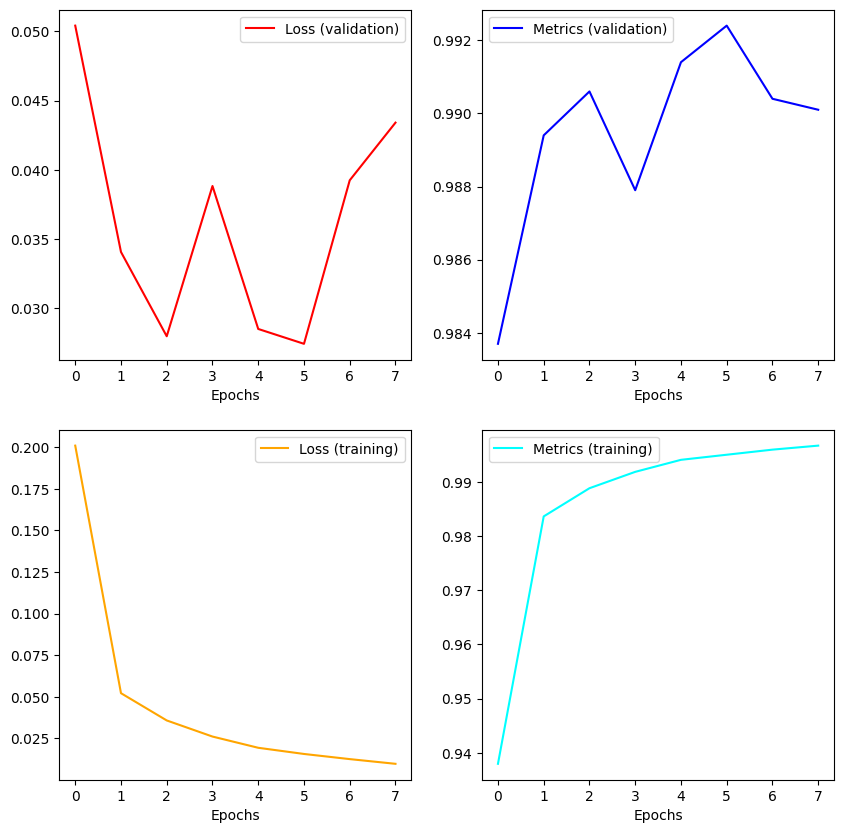

In [ ]:
'''
Adapted from Chollet's book "Deep learning with Python"
'''
# Tensorflow Keras packages
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# To run the Tensorflow Keras models set to True
run_tf_keras=True

# Hiperparameters
batch_size = 64
epochs=8

# Define the model
model = Sequential()

# ----->>> CONV2D
model.add(Conv2D(32,kernel_size=(3, 3),activation='relu',\
                 input_shape=input_shape))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
# <<<----- CONV2D

# ----->>> densily connected classifier
model.add(Dense(64, activation='relu')) # new dense layer added
model.add(Dense(output_neurons, activation='softmax'))
# <<<----- densily connected classifier

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

model.summary()

if(run_tf_keras):
    history=model.fit(x_train_conv2d,y1h_train,epochs=epochs,batch_size=batch_size,\
                      verbose=1,validation_data=(x_val_conv2d, y1h_val))

    model.save('./model_conv2d.keras')
    # history from training
    print("Keys:",history.history.keys())
    plot_keys=list(history.history.keys())
    plot_score("./",history,loss_name=plot_keys[0],metrics_name=plot_keys[1])

### Plotting the results: model summary, score and performance

In [ ]:
from tensorflow.keras import models

model=models.load_model("./model_conv2d.h5")
model.summary()

score = model.evaluate(x_val_conv2d, y1h_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)              